In [60]:
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

trn_ds = MNIST('', transform=img_transform, train=True, download=True)
val_ds = MNIST('', transform=img_transform, train=False, download=True)

batch_size = 128
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [62]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2), nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 5, stride=2, padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1), nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ConvAutoEncoder().to(device)
!pip install torch_summary
from torchsummary import summary
summary(model, torch.zeros(2, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 3, 3]            --
|    └─Conv2d: 2-1                       [-1, 32, 14, 14]          320
|    └─ReLU: 2-2                         [-1, 32, 14, 14]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 7, 7]            --
|    └─Conv2d: 2-4                       [-1, 64, 4, 4]            18,496
|    └─ReLU: 2-5                         [-1, 64, 4, 4]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 3, 3]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 7, 7]            18,464
|    └─ReLU: 2-8                         [-1, 32, 7, 7]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 3, 3]            --
|    └─Conv2d: 2-1                       [-1, 32, 14, 14]          320
|    └─ReLU: 2-2                         [-1, 32, 14, 14]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 7, 7]            --
|    └─Conv2d: 2-4                       [-1, 64, 4, 4]            18,496
|    └─ReLU: 2-5                         [-1, 64, 4, 4]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 3, 3]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 7, 7]            18,464
|    └─ReLU: 2-8                         [-1, 32, 7, 7]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

In [64]:
def train_batch(input,model,criterion,optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(input,model,criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001, weight_decay=1e-5)

In [66]:
from fastprogress import master_bar, progress_bar

num_epochs = 5
log = master_bar(range(num_epochs))

for epoch in log:
    log.write(f"Epoch {epoch + 1}/{num_epochs} started.")
    
    N = len(trn_dl)
    for ix, (data, _) in enumerate(progress_bar(trn_dl, parent=log)):
        loss = train_batch(data, model, criterion, optimizer)
        log.child.comment = f"Training Loss: {loss:.4f}"

    N = len(val_dl)
    for ix, (data, _) in enumerate(progress_bar(val_dl, parent=log)):
        loss = validate_batch(data, model, criterion)
        log.child.comment = f"Validation Loss: {loss:.4f}"
        

    log.write(f"Epoch {epoch + 1}/{num_epochs} completed.")

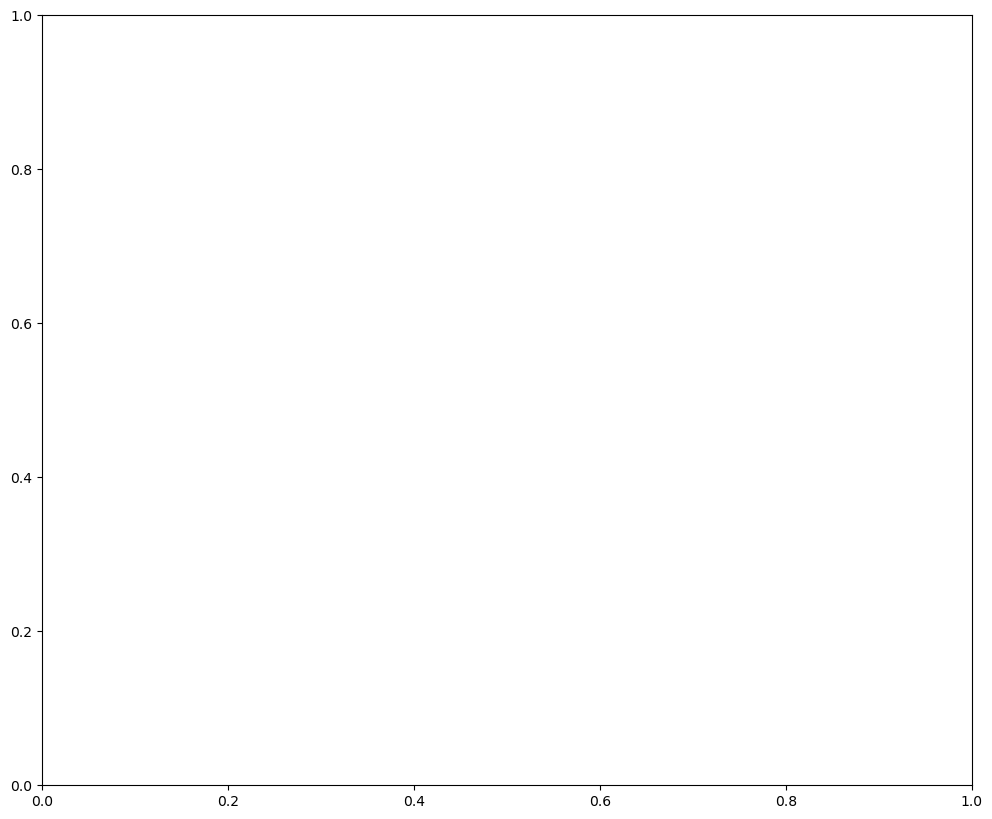

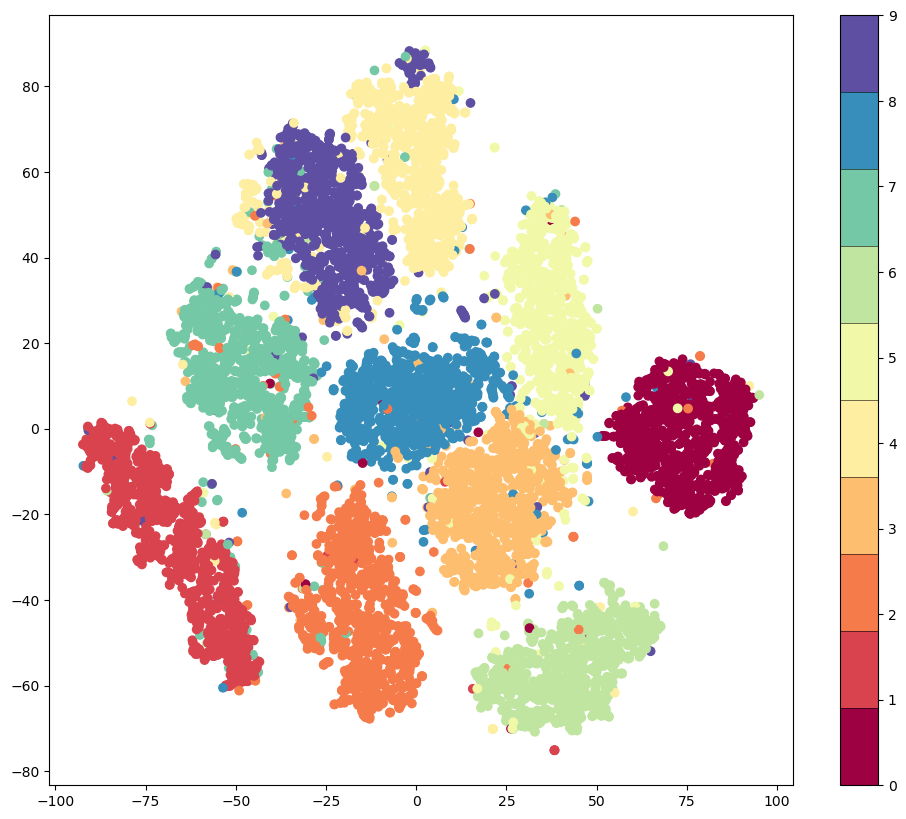

In [77]:
latent_vectors = []
classes = []

for im, clss in val_dl:
    # Passando as imagens pela rede e armazenando os vetores latentes
    latent_vectors.append(model.encoder(im).view(im.size(0), -1))
    classes.extend(clss)

latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy()

# Aplicando t-SNE
tsne = TSNE(n_components=2)
clustered = tsne.fit_transform(latent_vectors)

# Visualização
fig = plt.figure(figsize=(12, 10))
cmap = plt.get_cmap('Spectral', 10)
plt.scatter(*zip(*clustered), c=classes, cmap=cmap)
plt.colorbar(drawedges=True)
plt.show()
